In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from dateutil import parser
from dateutil.relativedelta import relativedelta
from collections import Counter
import math
import cartopy.crs as ccrs
import xarray as xr

In [2]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location)

reading outlooks 1
reading outlooks 2


c:\Users\miles\OneDrive\Documents\UW\Research\utils_filter.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outlooks = outlooks.append(gp.read_file(data_location + '/outlooks/' + mod_string + '_outlooks_2.shp'))


reading pph
reading storm reports


In [3]:
tz_conversions = {'PST': timedelta(hours=8),
                  'MST': timedelta(hours=7),
                  'CST': timedelta(hours=6),
                  'CSt': timedelta(hours=6),
                  'CSC': timedelta(hours=6),
                  'SCT': timedelta(hours=6),
                  'EST': timedelta(hours=5),
                  'ESt': timedelta(hours=5),
                  'PDT': timedelta(hours=7),
                  'MDT': timedelta(hours=6),
                  'CDT': timedelta(hours=5),
                  'EDT': timedelta(hours=4),
                  'HST': timedelta(hours=10),
                  'SST': timedelta(hours=11),
                  'GST': timedelta(hours=10),
                  'AKS': timedelta(hours=9),
                  'AST': timedelta(hours=4),
                  'UNK': timedelta(hours=5),
                  'GMT': timedelta(0)}

def get_reports_date_strings(date_times, timezones):
    # returns list of strings of date of given datetime and timezone (where day cutoffs are 12-12 UTC) formatted as 'YYYYMMDD0000'
    for datetime, timezone, i in zip(date_times, timezones, range(len(timezones))):
        #print(datetime + ' ' + timezone[:3])
        datetime = parser.parse(datetime)
        datetime = datetime + tz_conversions[timezone[:3]]
        #print(datetime)
        if (datetime.hour < 12):
            datetime = datetime - timedelta(days = 1)
        if datetime.year > 2049:
            datetime = datetime - relativedelta(years = 100)
        datetime = datetime.strftime("%Y%m%d") + '0000'
        if i == 0:
            ret = [datetime]
        else:
            ret.append(datetime)
    return ret

def get_pph_date_strings(times):
    # returns a list of strings of given dates formatted as 'YYYYMMDD0000'
    for datetime, i in zip(times, range(len(times))):
        string = datetime.dt.strftime("%Y%m%d").values + '0000'
        if i == 0:
            ret = [string]
        else:
            ret.append(string)
    return ret

In [4]:
reports['DATE'] = get_reports_date_strings(reports['BEGIN_DATE_TIME'], reports['CZ_TIMEZONE']) 
pph['time'] = get_pph_date_strings(pph.time) 
# subset outlooks into only one day 1, two day 2, and one day 3 categorical outlooks 
# day 3: cycle not -1. day 2: cycle not -1. Day 1: cycle 6. Category: categorical. # TODO: get prob by category 
#outlooks = outlooks[(((outlooks['DAY'] == 1) & (outlooks['CYCLE'] == 6)) | ((outlooks['DAY'] == 2) & (outlooks['CYCLE'] != -1)) | ((outlooks['DAY'] == 3) & (outlooks['CYCLE'] != -1)))
#        & (outlooks['CATEGORY'] == 'CATEGORICAL')]

# reset incicies
outlooks = outlooks.reset_index(drop=True)
reports = reports.drop(columns=['geometry'])

# Gridize reports -- will put into original gridize file after everything runs

In [ ]:
# filter reports to only be above severe thresholds

reports.loc[reports['MAGNITUDE'] == '', 'MAGNITUDE'] = 0
reports = reports[(reports['EVENT_TYPE'] == 'Tornado') | 
                  ((reports['EVENT_TYPE'] == 'Thunderstorm Wind') & (reports['MAGNITUDE'].astype(float) >= 50)) |
                  ((reports['EVENT_TYPE'] == 'Hail') & (reports['MAGNITUDE'].astype(float) >= 1))]

In [ ]:
# Create empty reports dataset: same coords and time, 3 hazard dimensions (and total dimension and T/F dimension?)
hazard_types= ['Wind', 'Hail', 'Tornado', 'Sig Wind', 'Sig Hail', 'Sig Tornado', 'Total Reports', 'Total Sig'] # TODO add true/false

report_dataset = xr.Dataset(
    data_vars=dict(
        lat=(['y', 'x'], pph['lat'].data),
        lon=(['y', 'x'], pph['lon'].data)
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        x=(['x'], pph['x'].data),
        y=(['y'], pph['y'].data),
        hazard=(['hazard'], hazard_types)
    ),
    attrs=dict(description="Number of each hazard type",
            grid = pph.grid),
)

report_dataset = report_dataset.assign(count = (('time', 'y', 'x', 'hazard'), np.full((len(report_dataset['time']), len(report_dataset['y']), len(report_dataset['x']), len(hazard_types)), 0)))
report_dataset['count'].mean()

In [6]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
resolution = 81271
grid_shift = 52
cent_lon = pph['lon'].sel(y=0, x=grid_shift).values
cent_lat = pph['lat'].sel(y=0, x=grid_shift).values
sp = (25, 25)
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = 52*resolution, false_northing= 0, standard_parallels=sp)

In [ ]:
# iterate through reports (filtered to only be severe as in labelling), adding 1 to appropriate count 
#               (nearest point? or within 25 mi? would leave out reports in "gap" between 4 25 mi circles. probably within 25 mi for technically correct definition. But can do nearest point and then check within 25 mi.)

for i, row in reports.iterrows(): # for each report
    date = row['DATE']
    if i % 100000 == 0:
        print('Row ' + str(i))
    
    if (date >= report_dataset['time'][0]) and (date <= report_dataset['time'][-1]): # reports in time frame of interest
        # get grid points (x and y) of report location
        if row['BEGIN_LON'] != '' and row['BEGIN_LAT'] != '':
            x, y = data_crs.transform_point(float(row['BEGIN_LON']), float(row['BEGIN_LAT']), src_crs=ccrs.PlateCarree())
            if not (math.isnan(x) or math.isnan(y)):
                x, y = (x/resolution, y/resolution)
                xgrid = round(x)
                ygrid = round(y)

                # check if report is within 25 mi of nearest gridpoint
                if np.sqrt((xgrid-x)**2 + (ygrid-y)**2) < .5 and xgrid >= 0 and xgrid <= 92 and ygrid >= 0 and ygrid <= 64: # half a grid point away is 25 miles

                    if row['EVENT_TYPE'] == 'Thunderstorm Wind':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Wind')] += 1
                        if float(row['MAGNITUDE']) >= 65:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Wind')] += 1

                    elif row['EVENT_TYPE'] == 'Hail':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Hail')] += 1
                        if float(row['MAGNITUDE']) >= 2:
                            report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Hail')] += 1

                    elif row['EVENT_TYPE'] == 'Tornado':
                        report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Tornado')] += 1
                        rating_str = row['TOR_F_SCALE']
                        if rating_str != 'EFU' and rating_str != '':
                            if int(rating_str[-1]) >= 2:
                                report_dataset['count'].loc[dict(time = date, x = xgrid, y = ygrid, hazard = 'Sig Tornado')] += 1

                    else:
                        raise Exception('Unexpected event type')
            

In [ ]:
# Add total counts and T/F
report_dataset['count'].loc[dict(hazard = 'Total Reports')] = report_dataset['count'].sel(hazard = 'Wind') + report_dataset['count'].sel(hazard = 'Hail') + report_dataset['count'].sel(hazard = 'Tornado')
report_dataset['count'].loc[dict(hazard = 'Total Sig')] = report_dataset['count'].sel(hazard = 'Sig Wind') + report_dataset['count'].sel(hazard = 'Sig Hail') + report_dataset['count'].sel(hazard = 'Sig Tornado')
report_dataset = report_dataset.assign(bool = (('time', 'y', 'x', 'hazard'), (report_dataset['count'] > 0).data))

In [ ]:
save_location = 'data/storm_reports/grid_reports.nc'
report_dataset.to_netcdf(save_location)

# Messing around with projections

In [19]:
# https://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID211 APPEARS TO SPECIFY
pph = xr.open_dataset('data' + '/pph/' + 'labelled' + '_pph.nc')
resolution = 81270.5
x_shift = 52
y_shift = 25 # in this test, the central lon and lat come from grid point [52, 0] (or [53, 1], with one-based indexing) in the PPH dataset
cent_lon = pph['lon'].sel(y=y_shift, x=x_shift).values
cent_lat = pph['lat'].sel(y=y_shift, x=x_shift).values
sp = (25, 25) # standard parallel
data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = x_shift*resolution, false_northing= y_shift*resolution, standard_parallels=sp)

In [20]:
arrx = np.zeros_like(pph['lat'])
arry = np.zeros_like(pph['lat'])

data_crs = ccrs.LambertConformal(central_latitude = cent_lat, central_longitude=cent_lon, false_easting = x_shift*resolution, false_northing= y_shift*resolution, standard_parallels=sp)

for testx in range(93):
    for testy in range(65): # test x and test y (starting with [0, 0]) are the indecies of the grid point from PPH we are comparing against
        x, y = data_crs.transform_point(pph['lon'].sel(x = testx, y = testy).values, 
                                        pph['lat'].sel(x = testx, y = testy).values, 
                                        src_crs=ccrs.PlateCarree()) # transforming the lat and lon at this gridpoint from PPH to our newly defined coordinate system should give back [x, y] 
        x, y = (x/resolution, y/resolution) # maybe there's something wrong with this?
        arrx[testy, testx] = x - testx
        arry[testy, testx] = y - testy



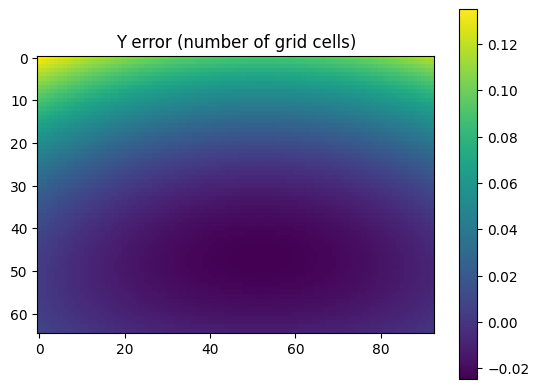

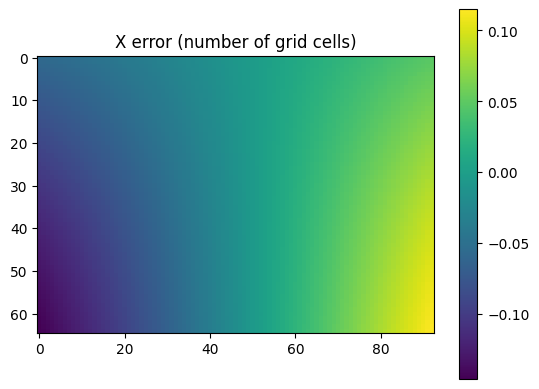

In [21]:
# displaying errors
im = plt.imshow(arry)
plt.title('Y error (number of grid cells)')
plt.colorbar(im)
plt.show()
im = plt.imshow(arrx)
plt.title('X error (number of grid cells)')
plt.colorbar(im)
plt.show()